<a href="https://colab.research.google.com/github/Preetham1928/Reinforcement_learning_Lab/blob/main/RL_Lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import gymnasium as gym
import numpy as np
import random


# 1) VALUE ITERATION

def value_iteration(P, nS, nA, gamma=0.99, theta=1e-8):
    V = np.zeros(nS)
    while True:
        delta = 0.0
        for s in range(nS):
            qsa = np.zeros(nA)
            for a in range(nA):
                for prob, s_next, reward, done in P[s][a]:
                    qsa[a] += prob * (reward + gamma * (0 if done else V[s_next]))
            v_new = np.max(qsa)
            delta = max(delta, abs(v_new - V[s]))
            V[s] = v_new
        if delta < theta:
            break
    # greedy policy
    pi = np.zeros((nS, nA))
    for s in range(nS):
        qsa = np.zeros(nA)
        for a in range(nA):
            for prob, s_next, reward, done in P[s][a]:
                qsa[a] += prob * (reward + gamma * (0 if done else V[s_next]))
        pi[s, np.argmax(qsa)] = 1.0
    return V, pi

# 2) POLICY ITERATION

def policy_iteration(P, nS, nA, gamma=0.99, eval_tol=1e-8):
    pi = np.ones((nS, nA)) / nA
    V = np.zeros(nS)
    stable = False
    while not stable:
        # Policy Evaluation
        while True:
            delta = 0.0
            for s in range(nS):
                v = 0.0
                for a in range(nA):
                    for prob, s_next, reward, done in P[s][a]:
                        v += pi[s, a] * prob * (reward + gamma * (0 if done else V[s_next]))
                delta = max(delta, abs(v - V[s]))
                V[s] = v
            if delta < eval_tol:
                break
        # Policy Improvement
        stable = True
        for s in range(nS):
            old_a = np.argmax(pi[s])
            qsa = np.zeros(nA)
            for a in range(nA):
                for prob, s_next, reward, done in P[s][a]:
                    qsa[a] += prob * (reward + gamma * (0 if done else V[s_next]))
            new_a = np.argmax(qsa)
            pi[s] = 0
            pi[s, new_a] = 1.0
            if new_a != old_a:
                stable = False
    return V, pi

# 3) MONTE CARLO CONTROL (First-visit, ε-greedy)

def mc_control_eps_greedy(env, episodes=20000, gamma=0.99, eps_start=1.0, eps_end=0.05):
    nA = env.action_space.n
    Q = {}
    returns = {}
    def get_Q(s):
        if s not in Q:
            Q[s] = np.zeros(nA)
        return Q[s]
    for ep in range(episodes):
        eps = max(eps_end, eps_start * (1 - ep / episodes))
        s, _ = env.reset()
        traj = []
        done = False
        while not done:
            q = get_Q(s)
            a = np.random.choice(nA) if random.random() < eps else np.argmax(q)
            s2, r, term, trunc, _ = env.step(a)
            traj.append((s, a, r))
            s = s2
            done = term or trunc
        G = 0
        visited = set()
        for (s_t, a_t, r_t) in reversed(traj):
            G = r_t + gamma * G
            if (s_t, a_t) not in visited:
                returns.setdefault((s_t, a_t), []).append(G)
                get_Q(s_t)[a_t] = np.mean(returns[(s_t, a_t)])
                visited.add((s_t, a_t))
    policy = {s: np.argmax(q) for s, q in Q.items()}
    return Q, policy

# ----------------------
# RUN DEMOS
# ----------------------
# Use FrozenLake (deterministic for better learning speed)
env = gym.make("FrozenLake-v1", is_slippery=False)
P = env.unwrapped.P
nS = env.observation_space.n
nA = env.action_space.n

print(" VALUE ITERATION ")
V_vi, pi_vi = value_iteration(P, nS, nA)
print("Optimal Value Function:", V_vi)
print("Optimal Policy:", np.argmax(pi_vi, axis=1))

print("\n POLICY ITERATION ")
V_pi, pi_pi = policy_iteration(P, nS, nA)
print("Optimal Value Function:", V_pi)
print("Optimal Policy:", np.argmax(pi_pi, axis=1))

print("\n MONTE CARLO CONTROL ")
Q_mc, policy_mc = mc_control_eps_greedy(env)
print("Learned Policy (MC):", policy_mc)


 VALUE ITERATION 
Optimal Value Function: [0.95099005 0.96059601 0.970299   0.96059601 0.96059601 0.
 0.9801     0.         0.970299   0.9801     0.99       0.
 0.         0.99       1.         0.        ]
Optimal Policy: [1 2 1 0 1 0 1 0 2 1 1 0 0 2 2 0]

 POLICY ITERATION 
Optimal Value Function: [0.95099005 0.96059601 0.970299   0.96059601 0.96059601 0.
 0.9801     0.         0.970299   0.9801     0.99       0.
 0.         0.99       1.         0.        ]
Optimal Policy: [1 2 1 0 1 0 1 0 2 1 1 0 0 2 2 0]

 MONTE CARLO CONTROL 
Learned Policy (MC): {0: np.int64(3), 1: np.int64(2), 4: np.int64(1), 8: np.int64(2), 9: np.int64(1), 13: np.int64(2), 2: np.int64(1), 3: np.int64(0), 10: np.int64(1), 14: np.int64(2), 6: np.int64(1)}


In [4]:
pip install gym


Episode 100000/500000
Episode 200000/500000
Episode 300000/500000
Episode 400000/500000
Episode 500000/500000
Q-values for state (20, 10, False) : [ 0.43337939 -0.8417603 ]


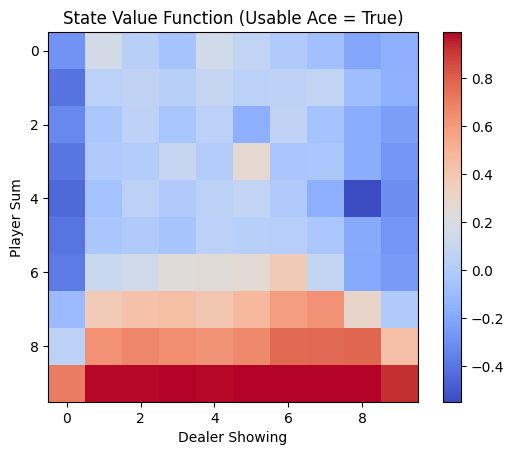

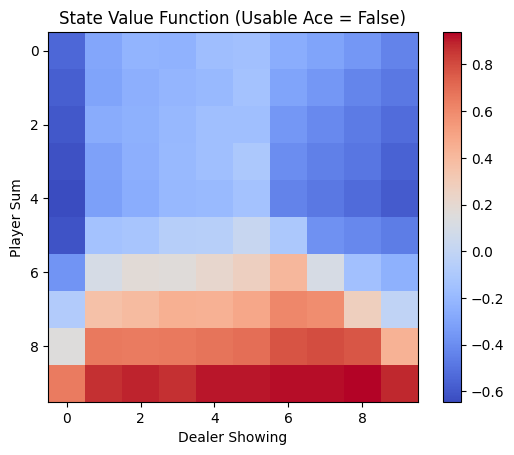

In [12]:
#Monte Carlo Policy Evaluation & Control (ε-greedy) – Blackjack Example
import gymnasium as gym # Changed from import gym
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

env = gym.make("Blackjack-v1", sab=True) # Changed env name

# ε-greedy policy
def epsilon_greedy_policy(Q, state, nA, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(nA)
    else:
        return np.argmax(Q[state])

# Generate an episode following policy π
def generate_episode(Q, epsilon, nA):
    episode = []
    state = env.reset()[0]
    done = False
    while not done:
        action = epsilon_greedy_policy(Q, state, nA, epsilon)
        next_state, reward, done, truncated, _ = env.step(action)
        episode.append((state, action, reward))
        state = next_state
    return episode

# Monte Carlo Control with ε-greedy
def mc_control_epsilon_greedy(num_episodes=500000, gamma=1.0, epsilon=0.1):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))  # Q[state][action]
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)

    for i_episode in range(1, num_episodes + 1):
        episode = generate_episode(Q, epsilon, env.action_space.n)
        G = 0
        visited = set()

        # Work backwards through episode
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = gamma * G + reward

            if (state, action) not in visited:
                visited.add((state, action))
                returns_sum[(state, action)] += G
                returns_count[(state, action)] += 1
                Q[state][action] = returns_sum[(state, action)] / returns_count[(state, action)]

        # Optional: print progress
        if i_episode % 100000 == 0:
            print(f"Episode {i_episode}/{num_episodes}")

    policy = {s: np.argmax(a) for s, a in Q.items()}
    return policy, Q

# Run the MC Control
final_policy, final_Q = mc_control_epsilon_greedy()

# Example: View Q-value for a specific state
sample_state = (20, 10, False)  # (player_sum, dealer_card, usable_ace)
print("Q-values for state", sample_state, ":", final_Q[sample_state])

# Optional Visualization of State Value

def plot_value_function(Q, usable_ace=True):
    value_fn = np.zeros((10, 10))
    for player_sum in range(12, 22):
        for dealer_card in range(1, 11):
            state = (player_sum, dealer_card, usable_ace)
            if state in Q:
                value_fn[player_sum - 12, dealer_card - 1] = np.max(Q[state])
            else:
                value_fn[player_sum - 12, dealer_card - 1] = 0

    plt.imshow(value_fn, cmap='coolwarm')
    plt.colorbar()
    plt.xlabel("Dealer Showing")
    plt.ylabel("Player Sum")
    plt.title("State Value Function (Usable Ace = " + str(usable_ace) + ")")
    plt.show()

# Plot both with and without usable ace
plot_value_function(final_Q, usable_ace=True)
plot_value_function(final_Q, usable_ace=False)